# Homework 2

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Matheus Raka Pradnyatama
* matheusraka@uchicago.edu

## HBS Case

### *ProShares Hedge Replication ETF*

***

# 1. The ProShares ETF Product

**Section 1 is not graded**, and you do not need to submit your answers. But you are encouraged to think about them, and we will discuss them.

## 1. Alternative ETFs

Describe the two types of investments referenced by this term.

## 2. Hedge Funds.

a. Using just the information in the case, what are two measures by which hedge funds are an attractive investment?

b. What are the main benefits of investing in hedge funds via an ETF instead of directly?

## 3. The Benchmarks

a. Explain as simply as possible how HFRI, MLFM, MLFM-ES, and HDG differ in their construction and purpose.

b. How well does the Merrill Lynch Factor Model (MLFM) track the HFRI?

c. In which factor does the MLFM have the largest loading? (See a slide in Exhibit 1.)

d. What are the main concerns you have for how the MLFM attempts to replicate the HFRI?

## 4. The HDG Product

a. What does ProShares ETF, HDG, attempt to track? Is the tracking error small?

b. HDG is, by construction, delivering beta for investors. Isn't the point of hedge funds to generate alpha? Then why would HDG be valuable?

c. The fees of a typical hedge-fund are 2% on total assets plus 20% of excess returns if positive. HDG's expense ratio is roughly 1% on total assets. What would their respective net Sharpe Ratios be, assuming both have a gross excess returns of 10% and volatility of 20%?

***

In [2]:
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import sys

pd.options.display.float_format = "{:,.4f}".format

from sklearn.linear_model import LinearRegression
from typing import Union, List

import warnings
warnings.filterwarnings("ignore")

# 2.  Analyzing the Data

Use the data found on Canvas, in <b>'proshares analysis data.xlsx'</b>. 

It has monthly data on financial indexes and ETFs from `Aug 2011` through `Sep 2024`.

## 1. 

For the series in the "hedge fund series" tab, report the following summary statistics:
* mean
* volatility
* Sharpe ratio

Annualize these statistics.

In [3]:
proshares_path = '/Users/matheus/Desktop/finm-portfolio-2024/data/proshares_analysis_data.xlsx'

hf_series = pd.read_excel(proshares_path,sheet_name='hedge_fund_series',index_col=0)
merrill_factors = pd.read_excel(proshares_path,sheet_name='merrill_factors',index_col=0)
other_data = pd.read_excel(proshares_path,sheet_name='other_data',index_col=0)

In [ ]:
def summary_statistics_annualized(returns, annual_factor = 12):
    """This functions returns the summary statistics for the input total/excess returns passed
    into the function"""
    
    summary_statistics = pd.DataFrame(index=returns.columns)
    summary_statistics['Mean'] = returns.mean() * annual_factor
    summary_statistics['Vol'] = returns.std() * np.sqrt(annual_factor)
    summary_statistics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(annual_factor)
    summary_statistics['Min'] = returns.min()
    summary_statistics['Max'] = returns.max()
    summary_statistics['Skewness'] = returns.skew()
    summary_statistics['Excess Kurtosis'] = returns.kurtosis()
    # VaR (.05) - the fifth quantile of historic returns
    summary_statistics['VaR (0.05)'] = returns.quantile(.05, axis = 0)
    # CVaR (.05) - the mean of the returns at or below the fifth quantile
    summary_statistics['CVaR (0.05)'] = returns[returns <= returns.quantile(.05, axis = 0)].mean()
    
    return summary_statistics

In [5]:
def calc_correlations(
    returns: pd.DataFrame,
    print_highest_lowest: bool = True,
    matrix_size: Union[int, float] = 7,
    return_heatmap: bool = True,
    keep_columns: Union[list, str] = None,
    drop_columns: Union[list, str] = None,
    keep_indexes: Union[list, str] = None,
    drop_indexes: Union[list, str] = None,
    drop_before_keep: bool = False
):
    returns = returns.copy()

    if 'date' in returns.columns.str.lower():
        returns = returns.rename({'Date': 'date'}, axis=1)
        returns = returns.set_index('date')
    returns.index.name = 'date'


    correlation_matrix = returns.corr()
    if return_heatmap:
        fig, ax = plt.subplots(figsize=(matrix_size * 1.5, matrix_size))
        heatmap = sns.heatmap(
            correlation_matrix, 
            xticklabels=correlation_matrix.columns,
            yticklabels=correlation_matrix.columns,
            annot=True,
        )

    if print_highest_lowest:
        highest_lowest_corr = (
            correlation_matrix
            .unstack()
            .sort_values()
            .reset_index()
            .set_axis(['asset_1', 'asset_2', 'corr'], axis=1)
            .loc[lambda df: df.asset_1 != df.asset_2]
        )
        highest_corr = highest_lowest_corr.iloc[lambda df: len(df)-1, :]
        lowest_corr = highest_lowest_corr.iloc[0, :]
        print(f'The highest correlation ({highest_corr["corr"]:.2%}) is between {highest_corr.asset_1} and {highest_corr.asset_2}')
        print(f'The lowest correlation ({lowest_corr["corr"]:.2%}) is between {lowest_corr.asset_1} and {lowest_corr.asset_2}')
    
    if return_heatmap:
        return heatmap
    else:
        return filter_columns_and_indexes(
            correlation_matrix,
            keep_columns=keep_columns,
            drop_columns=drop_columns,
            keep_indexes=keep_indexes,
            drop_indexes=drop_indexes,
            drop_before_keep=drop_before_keep
        )

## 2.

For the series in the "hedge fund series" tab, calculate the following statistics related to tail-risk.
* Skewness
* Excess Kurtosis (in excess of 3)
* VaR (.05) - the fifth quantile of historic returns
* CVaR (.05) - the mean of the returns at or below the fifth quantile
* Maximum drawdown - include the dates of the max/min/recovery within the max drawdown period.

There is no need to annualize any of these statistics.

In [6]:
summary_stats_hf_series = summary_statistics_annualized(hf_series, annual_factor = 12)
summary_stats_hf_series

,Mean,Vol,Sharpe,Min,Max,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05)
HFRIFWI Index,0.0483,0.0595,0.8120,-0.0908,0.0586,-0.9633,5.7631,-0.0243,-0.0375
MLEIFCTR Index,0.0363,0.0561,0.6464,-0.0532,0.0589,-0.2654,1.6316,-0.0282,-0.0359
MLEIFCTX Index,0.0346,0.0560,0.6182,-0.0524,0.0588,-0.2513,1.5959,-0.0281,-0.0358
HDG US Equity,0.0248,0.0584,0.4248,-0.0592,0.0583,-0.2542,1.7593,-0.0309,-0.0376
QAI US Equity,0.0257,0.0500,0.5130,-0.0563,0.0398,-0.4348,1.6059,-0.0179,-0.0327


In [7]:
def maximumDrawdown(returns):
    cum_returns = (1 + returns).cumprod()
    rolling_max = cum_returns.cummax()
    drawdown = (cum_returns - rolling_max) / rolling_max

    max_drawdown = drawdown.min()
    end_date = drawdown.idxmin()
    summary = pd.DataFrame({'Max Drawdown': max_drawdown, 'Bottom': end_date})

    for col in drawdown:
        summary.loc[col,'Peak'] = (rolling_max.loc[:end_date[col],col]).idxmax()
        recovery = (drawdown.loc[end_date[col]:,col])
        try:
            summary.loc[col,'Recover'] = pd.to_datetime(recovery[recovery >= 0].index[0])
        except:
            summary.loc[col,'Recover'] = pd.to_datetime(None)

        summary['Peak'] = pd.to_datetime(summary['Peak'])
        try:
            summary['Duration (to Recover)'] = (summary['Recover'] - summary['Bottom']) # Duration to recover = Recover - Bottom
        except:
            summary['Duration (to Recover)'] = None
            
        summary = summary[['Max Drawdown','Peak','Bottom','Recover','Duration (to Recover)']]

    return summary    

In [8]:
hf_series_drawdown = maximumDrawdown(hf_series)
hf_series_drawdown

,Max Drawdown,Peak,Bottom,Recover,Duration (to Recover)
HFRIFWI Index,-0.1155,2019-12-31,2020-03-31,2020-08-31,153 days
MLEIFCTR Index,-0.1243,2021-06-30,2022-09-30,2024-02-29,517 days
MLEIFCTX Index,-0.1244,2021-06-30,2022-09-30,2024-02-29,517 days
HDG US Equity,-0.1407,2021-06-30,2022-09-30,2024-07-31,670 days
QAI US Equity,-0.1377,2021-06-30,2022-09-30,2024-02-29,517 days


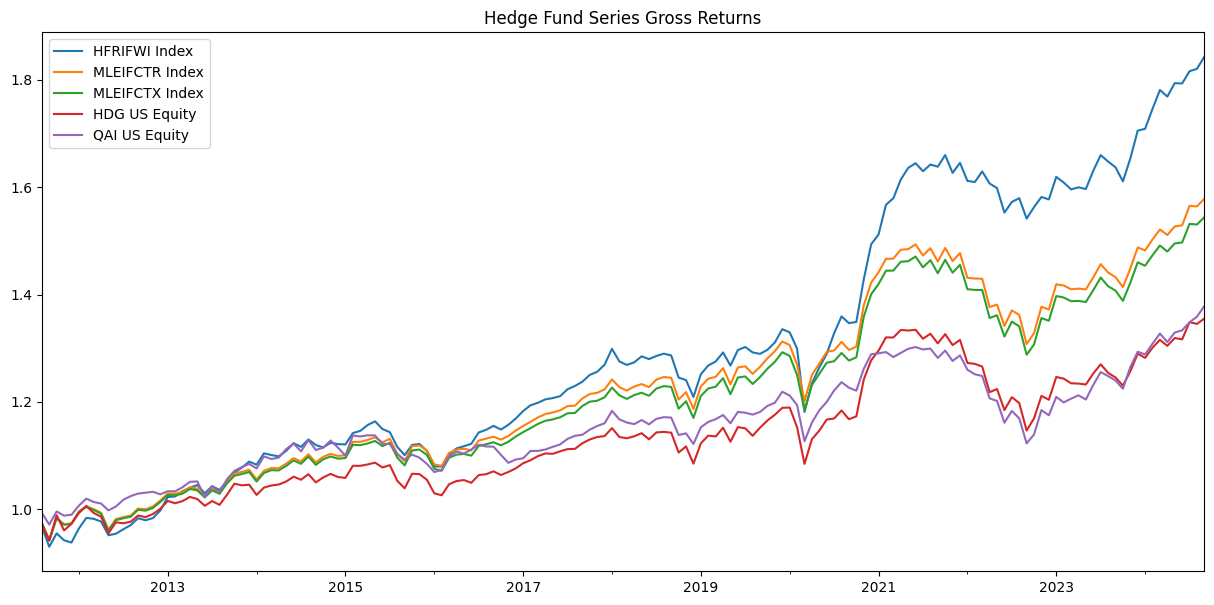

In [9]:
(hf_series + 1).cumprod().plot(figsize=(15, 7), title='Hedge Fund Series Gross Returns'); plt.show()

## 3. 

For the series in the "hedge fund series" tab, run a regression of each against SPY (found in the "merrill factors" tab.) Include an intercept. Report the following regression-based statistics:
* Market Beta
* Treynor Ratio
* Information ratio

Annualize these three statistics as appropriate.

In [10]:
x = sm.add_constant(merrill_factors['SPY US Equity'])

regression_stats = pd.DataFrame(index = ['Alpha', 'Beta for SPY (Market Beta)','Treynor Ratio','Information Ratio', 'Tracking Error'],columns = hf_series.columns)


adj = 12 # Annualized factor
for hf in hf_series.columns:
    
    y = hf_series[hf]
    
    model = sm.OLS(y,x).fit()

    alpha = model.params.iloc[0] * adj # Annualize this
    beta = model.params.iloc[1]
    treynor = adj * y.mean() / beta
    ir = np.sqrt(adj) * model.params.iloc[0] / model.resid.std()
    tracking_error = model.resid.std() * np.sqrt(adj)

    regression_stats[hf] = pd.Series([alpha, beta,treynor,ir, tracking_error],index = ['Alpha', 'Beta for SPY (Market Beta)','Treynor Ratio','Information Ratio', 'Tracking Error'])

regression_stats

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
Alpha,-0.0011,-0.0128,-0.0143,-0.0255,-0.0170
Beta for SPY (Market Beta),0.3461,0.3434,0.3422,0.3521,0.2984
Treynor Ratio,0.1395,0.1057,0.1011,0.0705,0.0860
Information Ratio,-0.0358,-0.4915,-0.5495,-0.8963,-0.6756
Tracking Error,0.0319,0.0260,0.0260,0.0284,0.0251


## 4. 

Discuss the previous statistics, and what they tell us about...

* the differences between SPY and the hedge-fund series?
* which performs better between HDG and QAI.
* whether HDG and the ML series capture the most notable properties of HFRI.

a) These hedge fund series have around 30-40% exosure to SPY as shown by their Beta^SPY. The Treynor ratio, which measures the level of returns per unit of market risk (proxied by SPY), ranged from ~0.7 to ~0.14. This indicates that these hedge fund strategies underperformed compared to SPY, even relative to the level of risk that was taken on. Lastly, the information ratio of all these strategies are negative, which reflects the negative alpha. In these regressions, alpa shows the hedge fund returns that could not be explained by the market. It seems that these hedge funds, performed poorly these past few years.

b) There are some notable difference between HDG and QAI. QAI has slightly less exposure to market risk than does HDG, with their difference in betas at ~0.05. As an investor who may be attracted to hedge funds due to their diversification benefits, this difference could be quite meaningful. Secondly, even proportional to the level of market risk, QAI has higher returns (less negative alpha).

c) Although HDG lags behind both HFRI and the ML series in terms of performance, both it and the ML series generally capture the most notable properties of HFRI.The level of market risk is quite similar to HFRI, which, as discussed by the case, is a driving factor of hedge fund investing. Again, these ETF returns are significantly lower than HFRI which could be a deterrent to potential investors.

## 5. 

Report the correlation matrix for these assets.
* Show the correlations as a heat map.
* Which series have the highest and lowest correlations?

<Axes: >

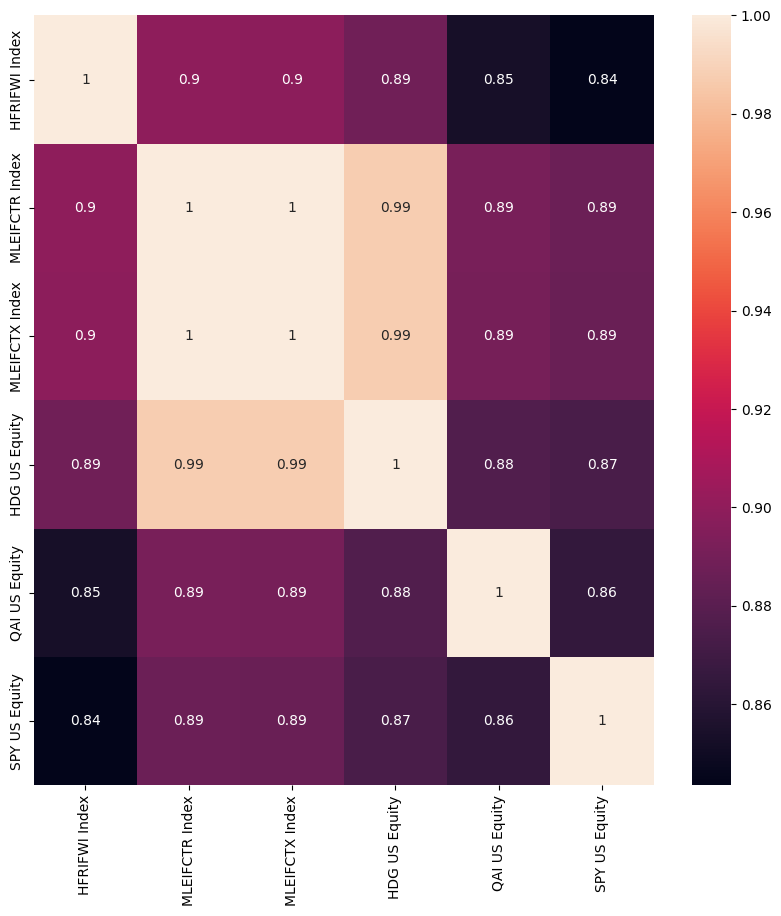

In [11]:
# Combining all assets
combined_df = pd.concat([hf_series, merrill_factors['SPY US Equity']], axis=1)

# Plotting the Correlation Matrix in Heatmap
fig, ax = plt.subplots(figsize=(10,10))
correlation_matrix = combined_df.corr()

sns.heatmap(correlation_matrix, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns, annot=True)

In [12]:
# Ranking the correlation and obtaining the max and min correlation 
corr_rank = correlation_matrix.unstack().sort_values().to_frame('Correlations')
corr_rank = corr_rank[corr_rank['Correlations']!=1]
pair_max = corr_rank.index[-1]
pair_min = corr_rank.index[0]

# Get the actual correlation values for those pairs # This code was built with the help of ChatGPT.com
max_correlation = corr_rank.loc[pair_max, 'Correlations']
max_correlation = round(max_correlation, 4)

min_correlation = corr_rank.loc[pair_min, 'Correlations']
min_correlation = round(min_correlation, 4)

print(f'Pair with the lowest correlation: {pair_min}, with a correlation of {min_correlation}')
print(f'Pair with the highest correlation: {pair_max}, with a correlation of {max_correlation}')

Pair with the lowest correlation: ('HFRIFWI Index', 'SPY US Equity'), with a correlation of 0.8435
Pair with the highest correlation: ('MLEIFCTX Index', 'MLEIFCTR Index'), with a correlation of 0.9999


## 6.

Replicate HFRI with the six factors listed on the "merrill factors" tab. Include a constant, and run the unrestricted regression,

$\newcommand{\hfri}{\text{hfri}}$
$\newcommand{\merr}{\text{merr}}$

$$\begin{align}
r^{\hfri}_{t} &= \alpha^{\merr} + x_{t}^{\merr}\beta^{\merr} + \epsilon_{t}^{\merr}\\[5pt]
\hat{r}^{\hfri}_{t} &= \hat{\alpha}^{\merr} + x_{t}^{\merr}\hat{\beta}^{\merr}
\end{align}$$

Note that the second equation is just our notation for the fitted replication.

a. Report the intercept and betas.
b. Are the betas realistic position sizes, or do they require huge long-short positions?
c. Report the R-squared.
d. Report the volatility of $\epsilon^{\merr}$, the tracking error.

In [13]:
def calc_multivariate_regression(y, X, intercept=True, adj=12):
    """
    Calculate a multivariate regression of y on X. Adds useful metrics such
    as the Information Ratio and Tracking Error. Note that we can't calculate
    Treynor Ratio or Downside Beta here.

    Args:
        y : target variable
        X : independent variables
        intercept (bool, optional): Defaults to True.
        adj (int, optional): Annualization factor. Defaults to 12.

    Returns:
        DataFrame: Summary of regression results
    """
    if intercept:
        X = sm.add_constant(X)

    model = sm.OLS(y, X, missing="drop")
    results = model.fit()
    summary = dict()

    inter = results.params.iloc[0] if intercept else 0
    betas = results.params.iloc[1:] if intercept else results.params

    summary["Alpha"] = inter * adj
    summary["R-Squared"] = results.rsquared

    X_cols = X.columns[1:] if intercept else X.columns

    for i, col in enumerate(X_cols):
        summary[f"{col} Beta"] = betas[i]

    summary["Information Ratio"] = (inter / results.resid.std()) * np.sqrt(adj)
    summary["Tracking Error"] = results.resid.std() * np.sqrt(adj)
    
    if isinstance(y, pd.Series):
        return pd.DataFrame(summary, index=[y.name])
    else:
        return pd.DataFrame(summary, index=y.columns)

In [14]:
proshares_path = '/Users/matheus/Desktop/finm-portfolio-2024/data/proshares_analysis_data.xlsx'
read_excel = partial(pd.read_excel, index_col=0, parse_dates=[0])
mer_factors = read_excel(proshares_path, sheet_name='merrill_factors')

y = hf_series[['HFRIFWI Index']]
x = sm.add_constant(merrill_factors)

with_int = calc_multivariate_regression(hf_series['HFRIFWI Index'], mer_factors).T
#no_int = calc_multivariate_regression(hf_series['HFRIFWI Index'], mer_factors, intercept=False).T
#regrs = pd.concat([with_int, no_int], axis=1)
#regrs.columns = ["HFRI w/Intercept", "HFRI w/o Intercept"]
#regrs

In [15]:
y = hf_series[['HFRIFWI Index']]
x = sm.add_constant(merrill_factors)

with_int = calc_multivariate_regression(hf_series['HFRIFWI Index'], mer_factors).T
with_int

,HFRIFWI Index
Alpha,0.0148
R-Squared,0.8397
SPY US Equity Beta,0.0365
USGG3M Index Beta,0.1463
EEM US Equity Beta,0.0816
EFA US Equity Beta,0.0846
EUO US Equity Beta,0.0288
IWM US Equity Beta,0.1451
Information Ratio,0.6225
Tracking Error,0.0238


## 6.b

The beta sizes are all very realistic, with none of the betas being above 1. We also don't have extreme long/short positions, which is good. However, we could make an argument that because all the factors are so correlated, we actually aren't getting a good estimate of beta and could perhaps achieve better out of sample replication by using fewer factors.

## 6.c

In [16]:
with_int_rsquared = with_int.loc["R-Squared", "HFRIFWI Index"]
with_int_rsquared = round(with_int_rsquared,2)
print(f"The R-Squared is {with_int_rsquared}")

The R-Squared is 0.84


## 6.d

In [17]:
with_int_tracking = with_int.loc["Tracking Error", "HFRIFWI Index"]
with_int_tracking = round(with_int_tracking,4)
print(f"The Tracking Error is {with_int_tracking}")


The Tracking Error is 0.0238


***

## 7.

Let's examine the replication out-of-sample (OOS).

Starting with $t = 61$ month of the sample, do the following:

* Use the previous 60 months of data to estimate the regression equation. 
This gives time-t estimates of the regression parameters, $\tilde{\alpha}^{\merr}_{t}$ and $\tilde{\beta}^{\merr}_{t}$.

* Use the estimated regression parameters, along with the time-t regressor values, $x^{\merr}_{t}$, calculate the time-t replication value that is, with respect to the regression estimate, built "out-of-sample" (OOS).

$$\hat{r}^{\hfri}_{t} \equiv \tilde{\alpha}^{\merr} + (x_{t}^{\merr})'\tilde{\beta}^{\merr}$$

* Step forward to $t = 62$, and now use $t = 2$ through $t = 61$ for the estimation. Re-run the steps above, and continue this process throughout the data series. Thus, we are running a rolling, 60-month regression for each point-in-time.

How well does the out-of-sample replication perform with respect to the target?

In [18]:
t = 60 # Use the previous 60 months of data to estimate the regression equation
n = len(hf_series['HFRIFWI Index']) # Predicting return of HFRI

data = hf_series[['HFRIFWI Index']].copy()
data['Replication'] = np.nan

for i in range(t, n):
    
    y = hf_series['HFRIFWI Index'].iloc[i - 60:i]
    x = sm.add_constant(merrill_factors).iloc[i - 60:i]
    
    m = sm.OLS(y,x).fit()
    
    oos_val = sm.add_constant(merrill_factors).iloc[i].to_numpy().reshape((7))

    rep_val = m.predict(oos_val)
    
    data['Replication'].iloc[i] = rep_val

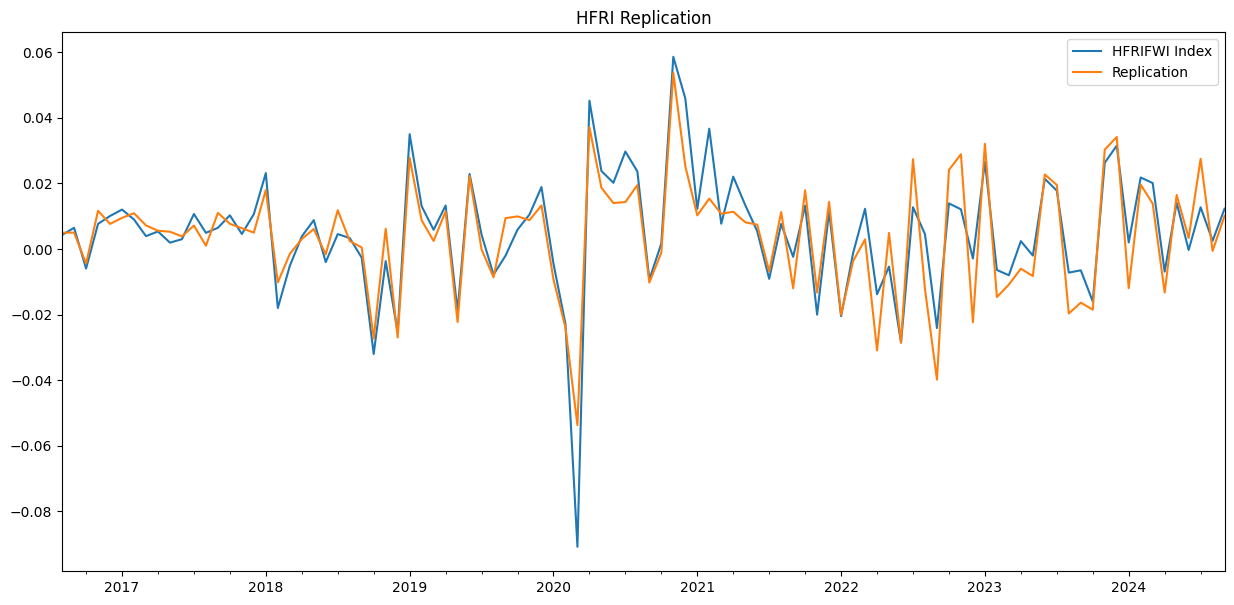

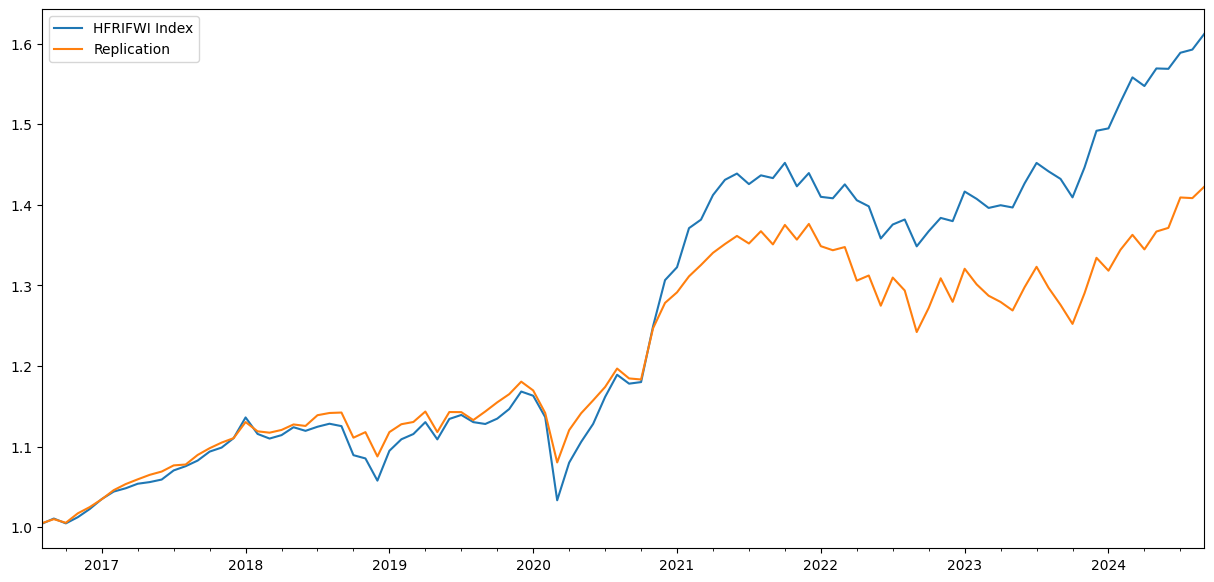

In [19]:
ax = data.dropna().plot(figsize=(15, 7)); (1 + data.dropna()).cumprod().plot(figsize=(15, 7));
ax.set_title("HFRI Replication")
plt.show()

In [20]:
# We can simplify by doing the following:

x = sm.add_constant(merrill_factors)
y = hf_series['HFRIFWI Index']

from statsmodels.regression.rolling import RollingOLS
rolling = RollingOLS(y,x,window=60).fit()
rolling_betas = rolling.params
replication_rolling = (rolling_betas.shift() * x).dropna().sum(axis=1)

In [21]:
oos_loss = (data.dropna().diff(axis=1)**2)['Replication'].sum()
oos_mean = data.dropna()['HFRIFWI Index'].mean()
oos_loss_null = ((data.dropna()['HFRIFWI Index'] - oos_mean)**2).sum()

oos_r2 = 1 - oos_loss / oos_loss_null

print(f'The OOS R-Squared of the replication is {round(oos_r2,4)}')

The OOS R-Squared of the replication is 0.7994


In [22]:
data.corr().round(3)

,HFRIFWI Index,Replication
HFRIFWI Index,1.0000,0.8980
Replication,0.8980,1.0000


Our replication portfolio does a decent job of tracking the index returns (R-squared of around 80%), as shown by the charts above and the ~90% correlation between the two. However, it is evident that the replication is lagging behind the cumulative returns of HFRIFWI.

One important consideration is whether or not we include the intercept in our "replication". On the one hand, it is useful to assess what sort of replication we could create if we had access to the alpha. On the other hand, we know that we can't directly get exposure to the alpha in our replication, so it may also make sense to assess our replication solely based on the betas (which are tradable). These considerations may lead to different choices in fitting the model, as shown below.

***

## 8.

We estimated the replications using an intercept. Try the full-sample estimation, but this time without an intercept.

$$\begin{align}
r^{\hfri}_{t} &= \alpha^{merr} + x_{t}^{\merr}\beta^{\merr} + \epsilon_{t}^{\merr}\\[5pt]
\check{r}^{\hfri}_{t} &= \check{\alpha}^{\merr} + x_{t}^{\merr}\check{\beta}^{\merr}
\end{align}$$

Report

* the regression beta. How does it compare to the estimated beta with an intercept, $\hat{\beta}^{\merr}$?

* the mean of the fitted value, $\check{r}^{\hfri}_{t}$. How does it compare to the mean of the HFRI?

* the correlations of the fitted values, $\check{r}^{\hfri}_{t}$ to the HFRI. How does the correlation compare to that of the fitted values with an intercept, $\hat{r}^{\hfri}_{t}$

Do you think Merrill and ProShares fit their replicators with an intercept or not?

In [23]:
proshares_path = '/Users/matheus/Desktop/finm-portfolio-2024/data/proshares_analysis_data.xlsx'
read_excel = partial(pd.read_excel, index_col=0, parse_dates=[0])
mer_factors = read_excel(proshares_path, sheet_name='merrill_factors')

y = hf_series[['HFRIFWI Index']]
x = sm.add_constant(merrill_factors)

with_int = calc_multivariate_regression(hf_series['HFRIFWI Index'], mer_factors).T
no_int = calc_multivariate_regression(hf_series['HFRIFWI Index'], mer_factors, intercept=False).T
regrs = pd.concat([with_int, no_int], axis=1)
regrs.columns = ["HFRI w/Intercept", "HFRI w/o Intercept"]
regrs

,HFRI w/Intercept,HFRI w/o Intercept
Alpha,0.0148,0.0000
R-Squared,0.8397,0.8452
SPY US Equity Beta,0.0365,0.0507
USGG3M Index Beta,0.1463,0.4993
EEM US Equity Beta,0.0816,0.0809
EFA US Equity Beta,0.0846,0.0791
EUO US Equity Beta,0.0288,0.0314
IWM US Equity Beta,0.1451,0.1427
Information Ratio,0.6225,0.0000
Tracking Error,0.0238,0.0239


Excluding the intercept term, we find that our weights change quite drastically. We now require a much large exposure to USGG3M, however the rest of our weights are relatively unchanged (can be observed from the betas).


In [24]:
# Method from HW Solution
y = hf_series[['HFRIFWI Index']]
x = merrill_factors

replication_model_no_int = sm.OLS(y,x).fit()

In [25]:
# No-Intercept Method from HW Solution
y = hf_series[['HFRIFWI Index']]
x = merrill_factors

# No-intercept model mean
no_int_predictedY_mean = round(replication_model_no_int.predict(x).mean(), 4)
print(f"Mean of No-Intercept Model: {no_int_predictedY_mean}")

Mean of No-Intercept Model: 0.0033


In [26]:
# Intercept model using HW Solution
y = hf_series[['HFRIFWI Index']]
x = sm.add_constant(merrill_factors)

replication_model = sm.OLS(y,x).fit()

# Intercept model mean (should be equal to the mean of the regressand)
with_int_predictedY_mean = round(replication_model.predict(sm.add_constant(x)).mean(), 4)
print(f"Mean of Intercept Model: {with_int_predictedY_mean}")

Mean of Intercept Model: 0.004


In [27]:
# Double check
y = hf_series[['HFRIFWI Index']]

Y_mean = y.mean().round(4) # Mean of HFRI
print(Y_mean)


HFRIFWI Index   0.0040
dtype: float64


Evidently the mean of the replication model with no intercept is lower than that of HFRIFWI. We do note however, that that the mean of the model that included the intercept is the same as the HFRIFWI if we include the intercept. If we do not, then the mean return of our replication is actually less than the no intercept model. Remember that we can trade the factors, but not the alpha.

In [28]:
merrill_factors = pd.read_excel(proshares_path,sheet_name='merrill_factors',index_col=0)
y = hf_series[['HFRIFWI Index']]
x = merrill_factors
print('Correlation of no intercept model to HFRIFWI: ', np.corrcoef(y['HFRIFWI Index'], replication_model_no_int.predict(x))[0][1])
print('Correlation of intercept model to HFRIFWI: ', np.corrcoef(y['HFRIFWI Index'], replication_model.predict(sm.add_constant(x)))[0][1])


Correlation of no intercept model to HFRIFWI:  0.9156937941419587
Correlation of intercept model to HFRIFWI:  0.9163384903623589


Including an intercept increases our correlation marginally.

It seems like ProShares and Merrill Lynch use the no intercept model. From the case study we know they have a large position in US Treasury Bills. This is more aligned with the no intercept model, which has a positive beta of 0.5 for USGG3M. In addition, we've found that we barely gain any correlation by including the intercept but we sacrifice a bit of mean return. Conceptually, it makes sense that if we want to replicate the index with the purpose of long-term investments we likely want to replicate the mean as well as the variation. The intercept ensures we are matching the variation in the factors, where we would like to match the overall level.

***

# 3.  Extensions
<i>This section is not graded, and you do not need to submit it. Still, we may discuss it in class, in which case, you would be expected to know it.

## 1. 

Merrill constrains the weights of each asset in its replication regression of HFRI. Try constraining your weights by re-doing 2.6.

* Use Non-Negative Least Squares (NNLS) instead of OLS.
* Go further by using a Generalized Linear Model to put separate interval constraints on each beta, rather than simply constraining them to be non-negative.

#### Hints
* Try using LinearRegression in scikit-learn with the parameter `positive=True`. 
* Try using GLM in statsmodels.

## 2. 

Let's decompose a few other targets to see if they behave as their name suggests.

* Regress HEFA on the same style factors used to decompose HFRI. Does HEFA appear to be a currency-hedged version of EFA?

* Decompose TRVCI with the same style factors used to decompose HFRI. The TRVCI Index tracks venture capital funds--in terms of our styles, what best describes venture capital?

* TAIL is an ETF that tracks SPY, but that also buys put options to protect against market downturns. Calculate the statistics in questions 2.1-2.3 for TAIL. Does it seem to behave as indicated by this description? That is, does it have high correlation to SPY while delivering lower tail risk?

## 3. 

The ProShares case introduces Levered ETFs. ProShares made much of its name originally through levered, or "geared" ETFs.

Explain conceptually why Levered ETFs may track their index well for a given day but diverge over time. How is this exacerbated in volatile periods like 2008?

## 4.

Analyze SPXU and UPRO relative to SPY.
- SPXU is ProShares -3x SPX ETF.
- UPRO is ProShres +3x SPX ETF.

Questions:
* Analyze them with the statistics from 2.1-2.3. 

* Do these two ETFs seem to live up to their names?

* Plot the cumulative returns of both these ETFs along with SPY.

* What do you conclude about levered ETFs?

***